Those of you who have already heard about GANs and are wondering *"What's the hype about?* should definitely go through this kernel to see the immense potential these new species of networks have. 

And for those of you who have heard the name for the first time, you will be all the more amazed when you learn about these networks.

# **First things first: what are they?**

`GAN`s are a class of Unsupervised Learning Algorithms that do much more than just recognizing image/voice, predicting, or translating. They implement deep neural networks or CNN and are comprised of two parts, pitting one against the other (thus the “adversarial”). These two parts are called the Generator and the Discriminator.

> **Generator** - The Generator takes the role of a forger and tries to create music/image/speech from random noise. It learns to map from a latent space to a particular data distribution of interest. It generally implements a Deconvolutional Network to do so.

> **Discriminator**- The Discriminator on the other hand takes the role of the evaluater and tries to distinguish the fake data (created by the Generator) from the real one. It is usually implemented as a Convolutional Network.

With that said what follows is a loop in which:
* The Generator tries to maximize the probability of fooling the Discriminator by making the images (for example) more close to real in each step, thereby making the Discriminator classify them as real.
* And the Discriminator guides the Generator to produce more realistic images by classifying its images as fake.

![](https://skymind.ai/images/wiki/GANs.png)







Let's fit this into an analogy. 
You can think of a GAN as a game of cat and mouse between a counterfeiter (Generator) and a cop (Discriminator). The counterfeiter is learning to create fake money, and the cop is learning to detect the fake money. Both of them are learning and improving. The counterfeiter is constantly learning to create better fakes, and the cop is constantly getting better at detecting them. Competition in this game drives both teams to improve their methods until the counterfeits are indistiguishable from the genuine or real money. 

GANs have incredible potential because they can learn to imitate any distribution of data. That is, GANs can learn to create worlds spookily similar to our own in any domain: images, music, speech.


GANs have a variety of applications ranging from reconstructing 3D model of objects from images to creating the 2018 painting *Edmond de Belamy*, which sold for $432,500 (Woah).
Some of them are:
* Image denoising
* Inpainting
* Super Resolution
* Structured Prediction
* Exploration in Reinforcement Learning 
* Image to Image Translation 

In this kernel, I'm implementing Deep Convolutional GAN based on this paper on [DCGAN](https://arxiv.org/pdf/1511.06434.pdf) which is in contrast to builds on [Ian Goodfellow's paper](http://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf). Goodfellow's paper is the first paper on GAN and implements a dense network both in the generator and the discriminator rather than a CNN. I am using the images (without class labels) from the **CIFAR_10** Dataset. These images, along with the fake ones, will be fed in batches to the Discriminator. Let's take a look at the steps our GAN will follow:

1. The Generator takes in random numbers and returns an image.
2. This generated image is fed into the Discriminator alongside a stream of images taken from the actual dataset.
3. The Discriminator takes in both real and fake images and returns probabilities: a number between `0` and `1`, with `1` representing a prediction of authenticity and `0` representing a fake.

There are two feedback loops: 

1. The Discriminator is in a feedback loop with the ground truth of the images (are they real or fake), which we know.
2. The Generator is in a feedback loop with the Discriminator (did the Discriminator label it real or fake, regardless of the truth).

Without any further delay, let's import the libraries, load the dataset, and get going.

In [1]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam,SGD
import keras
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
# print(os.listdir("../input"))
print(os.getcwd())


Using TensorFlow backend.


/home/jovyan/template_bh/notebooks


In [2]:
from os import listdir, makedirs
from os.path import join, exists, expanduser

cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
datasets_dir = join(cache_dir, 'datasets') # /cifar-10-batches-py
if not exists(datasets_dir):
    makedirs(datasets_dir)


!cp /home/jovyan/template_bh/data/cifar-10-python.tar.gz ~/.keras/datasets/
!ln -s  ~/.keras/datasets/cifar-10-python.tar.gz ~/.keras/datasets/cifar-10-batches-py.tar.gz
!tar xzvf ~/.keras/datasets/cifar-10-python.tar.gz -C ~/.keras/datasets/

ln: failed to create symbolic link '/home/jovyan/.keras/datasets/cifar-10-batches-py.tar.gz': File exists
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [3]:
# Load CIFAR10 data
(X_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Select a single class images (birds)
X_train = X_train[y_train.flatten() == 2]

In [4]:
# Input shape
img_rows = 32
img_cols = 32
channels = 3
        
img_shape = (img_rows, img_cols, channels)        
latent_dim = 100

## **The Generator** 


To learn a generator distribution p<sub>g</sub> over data `x`, the Generator builds a mapping function from a prior noise distribution p<sub>z</sub>(z) to data space as G(z). The Discriminator outputs a single scalar representing the probability that `x` came from training data rather than p<sub>g</sub>.

G and D are both trained simultaneously: we adjust parameters for G to minimize log(1 - D(G(z)) and adjust parameters for D to minimize logD(x), as if they are following the two-player min-max game with value function V (G;D):

![](https://github.com/Ibtastic/Generative-Adversarial-Networks/raw/master/GAN/loss.png)

* In the Generator we use a method called  [Upsampling](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0) to produce images. I have used `Upsampling2D` but `TransposeConv2d` + `stride` or `PixelShuffle` could be used alternatively. 



In [5]:
def build_generator():

        model = Sequential()

        model.add(Dense(128 * 8 * 8, activation="relu", input_dim=latent_dim))
        model.add(Reshape((8, 8, 128)))
        
        model.add(UpSampling2D())#upsamples to 16*16*128
        
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(UpSampling2D()) #upsamples to 32*32*128
        
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(Conv2D(channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        #outputs an image of 32*32*3

        noise = Input(shape=(latent_dim,))
        img = model(noise)

        return Model(noise, img)

## **The Discriminator**

The Discriminator is also a CNN with leaky `ReLU` activations. Many activation functions will work fine with this basic GAN architecture. However, leaky `ReLU`s are very popular because they help the gradients flow easier through the architecture.

A regular `ReLU` function works by truncating negative values to `0`. This has the effect of blocking the gradients to flow through the network. Instead of the function being `0`, leaky `ReLU`s allow a small negative value to pass through. That is, the function computes the greatest value between the features and a small factor.
Leaky `ReLU`s represent an attempt to solve the dying `ReLU` problem. This situation occurs when the neurons get stuck in a state in which `ReLU` units always output `0`s for all inputs. For these cases, the gradients are completely shut to flow back through the network.

> *This is especially important for GANs since the only way the Generator has to learn is by receiving the gradients from the Discriminator.*

Finally, the Discriminator needs to output probabilities. We use a `Sigmoid Activation` for that.

In [6]:
def build_discriminator():

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        #no normalization for the first layer 
        
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

A lot of changes have been made in GAN's Architecture since Goodfeloow's original paper, but some things remain the same :
* Normalizing the input
* The activation function in all but the last layer of the Generator must be a `ReLU`.
* The activation in the last layer of the Generator, which is a Dense Layer, is `tanh activation`.
* Same goes for the Discriminator, all the layers except the last have `ReLU` as activtaion and the last Dense layer uses `Sigmoid Activation`.
* We use `binary_cross_entropy` method to calculate loss in both the adversaries. (Though in some papers like [Wasserstein gan](https://arxiv.org/pdf/1701.07875.pdf) different loss functions are used).

Now some hacks/tips that have been introduced in papers in the last few years to make GANs better are:
* Using `BatchNormalization` in all layers except the input layer in the Generator and the output layer in the Discriminator.
* Using `Adam Optimizer` for the Generator and SGD for the Discriminator.
* Adding some random noise to the labels before feeding them to the discriminator.
* Sampling from a Gaussian Distribution instead of a Uniform distribution.
* Construct different mini-batches for real and fake, i.e. each mini-batch needs to contain only all real images or all generated images.
* Pre-training the Discriminator.
* Adding some noise to the images before feeding them to the discriminator.

It's not necessary that all of the above tricks will work for your model. You will have to find the ones that do.



In [7]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
            optimizer=Adam(0.0002,0.5),
            metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))

In [8]:
def show_imgs(epoch):
        r, c = 4,4
        noise = np.random.normal(0, 1, (r * c,latent_dim))
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()

In [9]:
def show_losses(losses):
    losses = np.array(losses)
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()
    plt.show()

Time to train the model! 

/srv/conda/envs/notebook/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/srv/conda/envs/notebook/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.284721] [G loss: 0.619662]


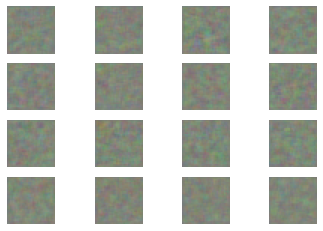

/srv/conda/envs/notebook/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.265477] [G loss: 1.516024]


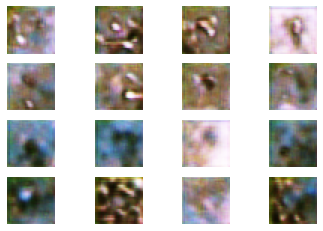

2000 [D loss: 0.327680] [G loss: 0.972319]


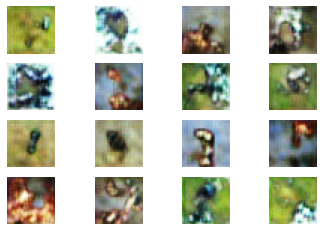

3000 [D loss: 1.079726] [G loss: 0.834174]


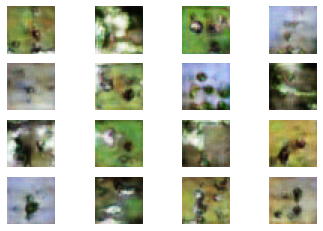

4000 [D loss: 0.645779] [G loss: 1.070052]


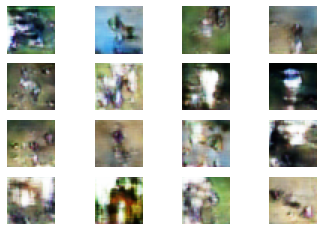

5000 [D loss: 0.498043] [G loss: 1.089548]


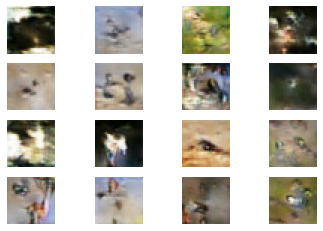

6000 [D loss: 0.794050] [G loss: 0.879366]


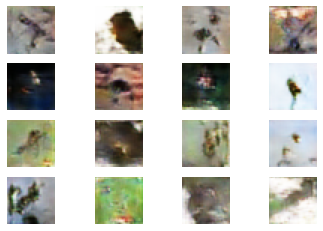

7000 [D loss: 0.721837] [G loss: 0.879526]


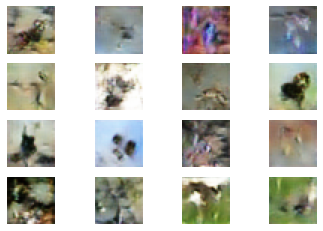

8000 [D loss: 0.912823] [G loss: 1.471383]


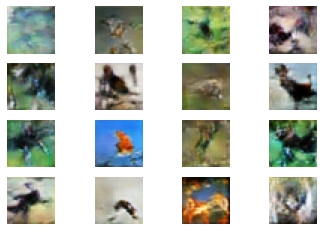

9000 [D loss: 1.549808] [G loss: 0.879013]


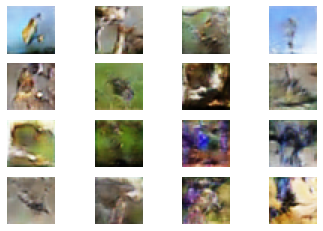

10000 [D loss: 0.450553] [G loss: 1.337083]


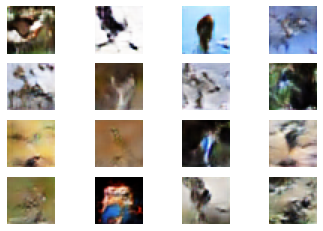

11000 [D loss: 0.676097] [G loss: 1.080480]


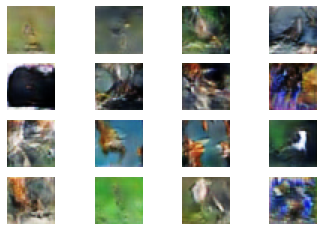

12000 [D loss: 0.689376] [G loss: 1.052600]


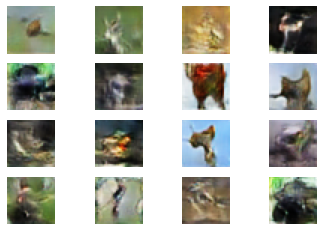

13000 [D loss: 0.783571] [G loss: 0.849771]


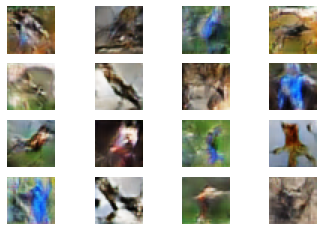

14000 [D loss: 0.608089] [G loss: 1.336366]


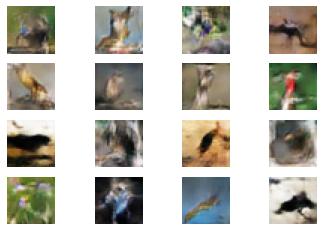

In [10]:
epochs=15000
batch_size=32
display_interval=1000
losses=[]

#normalizing the input
X_train = X_train / 127.5 - 1.
        

        # Adversarial ground truths
valid = np.ones((batch_size, 1))
        #let's add some noise 
valid += 0.05 * np.random.random(valid.shape)
fake = np.zeros((batch_size, 1))
fake += 0.05 * np.random.random(fake.shape)

for epoch in range(epochs):

            
            #  Train Discriminator
            

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_imgs = generator.predict(noise)
            

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            
            #  Train Generator
            

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = combined.train_on_batch(noise, valid)
            
            # Plot the progress
            if epoch % display_interval==0:
                print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
                show_imgs(epoch)
            if epoch % 1000==0:
                losses.append((d_loss[0],g_loss))
                

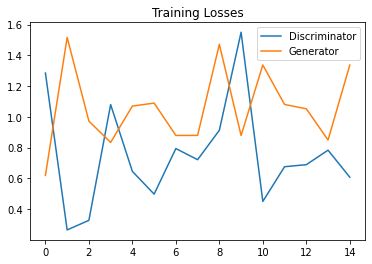

In [11]:
show_losses(losses)

Let's have a look at the original images. It will help us to compare how well our generator did. (I have only selected the bird images for training.)

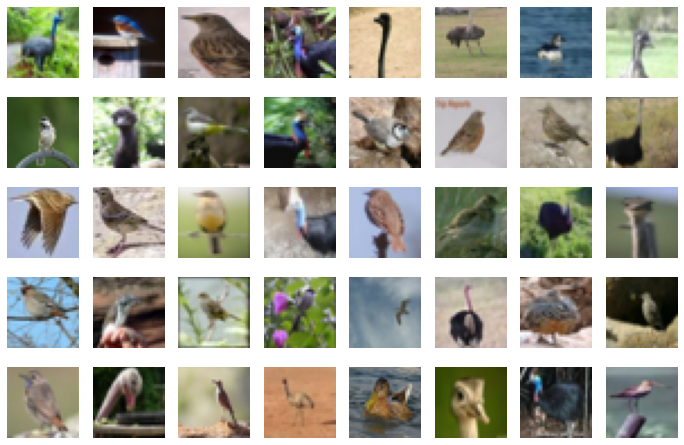

In [16]:
s=X_train[:40]
s = 0.5 * s + 0.5
f, ax = plt.subplots(5,8, figsize=(12,8))
for i, img in enumerate(s):
        ax[i//8, i%8].imshow(img)
        ax[i//8, i%8].axis('off')
        
plt.show()

Some images produced by the generator after training for 30000 epochs.

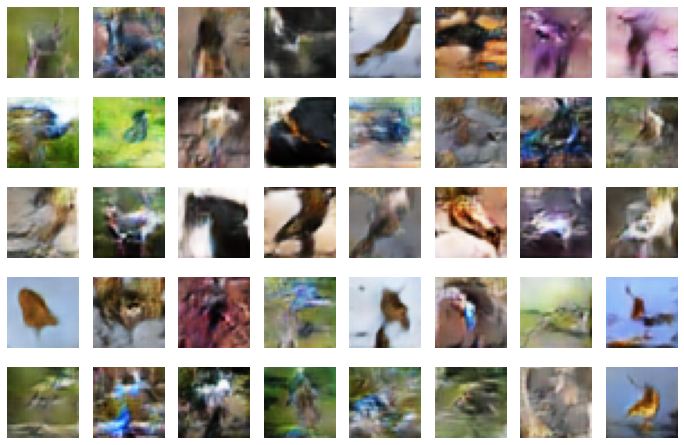

In [12]:
noise = np.random.normal(size=(40, latent_dim))
generated_images = generator.predict(noise)
generated_images = 0.5 * generated_images + 0.5
f, ax = plt.subplots(5,8, figsize=(12,8))
for i, img in enumerate(generated_images):
        ax[i//8, i%8].imshow(img)
        ax[i//8, i%8].axis('off')
        
plt.show()

These images are far from perfect and can be improved by more training or some hacks, but I think they are pretty amazing given the fact that they are generated from nothing (random noise actually).

I suggest that you read Goodfellow's [paper](https://arxiv.org/pdf/1406.2661.pdf) that introduced this breakthrough idea.

![](https://skymind.ai/images/wiki/GANdancers.png)



Some might be wondering "why haven't I trained the network on all the class of images ?" The answer is this network won't do well on multi-class data (you can check it yourself) because of a problem called **mode collapse**.

**References**:

https://skymind.ai/wiki/generative-adversarial-network-gan

https://github.com/eriklindernoren/Keras-GAN